# Libraries

In [1]:
import os
import sys
import glob
import pickle

import copy as cp
import itertools as it

import seaborn as sns
import numpy   as np
import pandas  as pd
import healpy  as hp

import scipy
import pickle


from astropy.io import fits
from astropy.wcs import WCS

import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

from spectral_cube import SpectralCube

import matplotlib.pyplot as plt
import matplotlib        as mpl

plt.rcParams["font.family"] = 'STIXGeneral'

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker  import AutoMinorLocator    

import h5py as h5

# Paths

In [ ]:
base  = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC   = os.path.join(askap, 'LMC')

LMC_plots = os.path.join(LMC, 'plots')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')

data_path = os.path.join(askap, 'data')

data_path = os.path.join(askap, 'data')
LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')
BIGHICAT_data_path = os.path.join(data_path, 'BIGHICAT')

hires_data = os.path.join(LMC_data_path, 'hires')
em_spectra_path = os.path.join(hires_data, 'neighbour_emission_spectra')
hires_results = os.path.join(hires_data, 'results')
hires_em_data = os.path.join(hires_data, 'cube')
hires_em_subcube_data = os.path.join(hires_em_data, 'subcubes')
hires_abs_data = os.path.join(hires_data, 'abs')
hires_em_profile_path = os.path.join(hires_data, 'em_profiles')
abscatv2_data_path = os.path.join(hires_data, 'abscatv2')
abs_dr3_data_path = os.path.join(hires_data, 'absdr3')

GASS_data_path = os.path.join(LMC_data_path, 'GASS')


dust_data_path = os.path.join(data_path, 'dust')
dust_data_path

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = os.path.join( parent_dir, 'gaussfit')
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = os.path.join( parent_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)
script_dir

In [7]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import config.config as cf

sys.path.append(parent_dir)

from mpfit import mpfit

# Fcn

In [9]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    
    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close() 

    print(f"Cube shape: {c.shape}")

    del dat

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

In [ ]:
# Define customized function
def avg_std(col):
    return np.sqrt(np.sum(col**2))

# Approximate locations of LMC and SMC

In [17]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

# Read BIGHICAT

In [18]:
bighicat_file = os.path.join(BIGHICAT_data_path, 'all_unique_LOS_new.csv')
bighicat_df = pd.read_csv(bighicat_file)
bighicat_df = bighicat_df[np.isfinite(bighicat_df.ra.values)]
bighicat_df = bighicat_df[bighicat_df.f_CNM_LOS > 0.]
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

199 30


In [19]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,J17304,MACH,75.772200,33.067700,262.685109,49.106959,2.500000,0.120000,0.880000,0.300000,...,0.041254,0.127889,-17.716097,-0.306228,-0.234197,17.608982,0.372730,0.057,NaN,NaN
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN


In [20]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [21]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_sigfcnm = bighicat_fcnm*0.1
bighicat_av = bighicat_df['AV_2013']

In [22]:
bighicat_gl = bighicat_df.lon.values
bighicat_gb = bighicat_df.lat.values

In [23]:
bighicat_ncomp = bighicat_df.ncomps.values

In [24]:
bighicat_non_abs_df = bighicat_df[bighicat_df.ncomps == 0]
bighicat_non_abs_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
347,J16114,MACH,64.5488,46.9059,242.951971,40.672200,0.69,0.05,0.95,0.0345,...,0.013145,0.040749,28.752806,-0.272594,0.230843,16.234470,0.304221,0.058,NaN,NaN
356,J16574,MACH,74.3683,38.4778,254.445018,48.142231,1.44,0.01,0.99,0.0144,...,0.027691,0.085842,0.163636,-1.077122,-1.168932,18.540604,0.225732,0.038,NaN,NaN
359,J17024,MACH,83.3471,37.3166,255.695643,55.277368,1.36,0.02,0.98,0.0272,...,0.025312,0.078468,5.028883,0.072909,0.020911,17.781618,0.258035,0.044,NaN,NaN


### BIGHICAT high latitudes

In [27]:
blim = 10.
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [28]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [29]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

In [30]:
bighicat_glon = hghlat_df.lon.values
bighicat_glat = hghlat_df.lat.values

### BIGHICAT components

In [31]:
bighicat_cpn_file = os.path.join(BIGHICAT_data_path, 'all_unique_CNM_det_gaussian_components_new.csv')
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [32]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [33]:
blim = 10.
hghlat_cpn_df = bighicat_cpn_df[(abs(bighicat_cpn_df.lat) > blim) & (bighicat_cpn_df.Ts.values < 1200.) & (bighicat_cpn_df.Ts.values > 0.)]
print(hghlat_cpn_df.shape)
hghlat_cpn_df.head()

(612, 41)


,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.079088,0.001155,0.036975,0.114623,16.987488,5.668997,-10.984881,19.149420,0.188328,0.046
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042


In [34]:
bighicat_taucnm = hghlat_cpn_df.tau.values
bighicat_sigtaucnm = hghlat_cpn_df.e_tau.values

bighicat_tscnm = hghlat_cpn_df.Ts.values
bighicat_sigtscnm = hghlat_cpn_df.e_Ts.values

bighicat_cpn_glon = hghlat_cpn_df.lon.values
bighicat_cpn_glat = hghlat_cpn_df.lat.values

In [35]:
hghlat_cpn_df[['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS']]

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,...,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,...,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,J17305,MACH,62.989309,31.515281,0.265273,0.004244,1.766504,0.032188036802595556,-1.721723,0.013781610396698542,...,0.097596,-0.549130,0.503466,0.371817,0.021779,35.272140,1.061401,1.0,3.340000,0.080000
1366,J17395,MACH,74.222149,31.396336,0.093102,0.001962,1.915317,0.04561607903694073,0.509023,0.01957865050933494,...,0.100540,0.162645,0.951671,0.660107,0.037285,163.375894,4.405454,1.0,2.100000,0.010000
1367,J17403,MACH,79.563304,31.748315,0.160304,0.002752,1.888898,0.06312492069606991,-1.029581,0.02805279460356263,...,0.028011,-1.366541,0.363143,0.164376,0.010449,27.985547,1.661898,2.0,2.930000,0.010000
1368,J17403,MACH,79.563304,31.748315,0.108895,0.003599,1.358413,0.0668096394427551,0.910594,0.03310903642575238,...,0.000062,0.774825,0.327112,0.134972,0.008130,38.876964,1.957794,2.0,2.930000,0.010000


In [36]:
bighicat_cpn_glon[bighicat_cpn_glon < 0.] = bighicat_cpn_glon[bighicat_cpn_glon < 0.] + 360.

In [37]:
hghlat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [38]:
hghlat_cpn_df.Ts

0       941.344712
1        17.835869
2       196.428242
5        16.656050
6       162.345752
           ...    
1365     35.272140
1366    163.375894
1367     27.985547
1368     38.876964
1369    104.572570
Name: Ts, Length: 612, dtype: float64

In [39]:
hghlat_cpn_df.e_Ts

0       30.798667
1        1.480552
2        5.449175
5        2.485132
6        4.904859
          ...    
1365     1.061401
1366     4.405454
1367     1.661898
1368     1.957794
1369     7.306931
Name: e_Ts, Length: 612, dtype: float64

# Ts_mean: BIGHICAT

In [42]:
# Define a function to calculate weighted mean and uncertainty
def weighted_mean_with_uncertainty(df_group):
    weighted_mean = np.average(df_group['Ts'], weights=df_group['NHI'])
    weighted_variance = np.average((df_group['Ts'] - weighted_mean) ** 2, weights=df_group['NHI'])
    weighted_uncertainty = np.sqrt(weighted_variance + np.average(df_group['e_Ts'] ** 2, weights=df_group['NHI']))
    return pd.Series([weighted_mean, weighted_uncertainty], index=['weighted_mean', 'weighted_uncertainty'])

# Group by column 'c' and calculate the weighted mean for each group
grouped_df = hghlat_cpn_df.groupby('source').apply(weighted_mean_with_uncertainty)

grouped_df = grouped_df.reset_index().sort_values('source')
bighi_tspin_mean = grouped_df['weighted_mean'].values
bighi_sigtspin_mean = grouped_df['weighted_uncertainty'].values

grouped_df

,source,weighted_mean,weighted_uncertainty
0,1055+018,941.344712,30.798667
1,3C018A,170.334629,63.284429
2,3C018B,144.305968,48.214318
3,3C041A,348.775828,28.589475
4,3C041B,148.891413,15.546528
...,...,...,...
209,P1117+14,208.343949,NaN
210,PKS0742,164.076921,9.844056
211,PKS1607,102.050893,33.063119
212,PKS2127,567.259758,313.862817


In [43]:
bighi_src_gl = []
bighi_src_gb = []
bighi_nhi_src = []
for srci in grouped_df['source'].values:
    bighi_src_gl.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['lon'].iloc[0])
    bighi_src_gb.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['lat'].iloc[0])
    bighi_nhi_src.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['NHI_LOS'].iloc[0])

bighi_src_gl = np.array(bighi_src_gl)
bighi_src_gb = np.array(bighi_src_gb)
bighi_nhi_src = np.array(bighi_nhi_src)
len(bighi_nhi_src)

214

In [44]:
bighicat_cpn_df[['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS']]

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649
3,3C018A,21-SPONGE,118.623255,-52.731718,0.084064,0.003265,1.491306,0.06251029338893384,-4.954399,0.020768842391248377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.287702,0.523649
4,3C018A,21-SPONGE,118.623255,-52.731718,0.007436,0.002707,0.745783,0.31345678134704164,24.367670,0.13311283917109765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.287702,0.523649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,J17305,MACH,62.989309,31.515281,0.265273,0.004244,1.766504,0.032188036802595556,-1.721723,0.013781610396698542,...,0.097596,-0.549130,0.503466,0.371817,0.021779,35.272140,1.061401,1.0,3.340000,0.080000
1366,J17395,MACH,74.222149,31.396336,0.093102,0.001962,1.915317,0.04561607903694073,0.509023,0.01957865050933494,...,0.100540,0.162645,0.951671,0.660107,0.037285,163.375894,4.405454,1.0,2.100000,0.010000
1367,J17403,MACH,79.563304,31.748315,0.160304,0.002752,1.888898,0.06312492069606991,-1.029581,0.02805279460356263,...,0.028011,-1.366541,0.363143,0.164376,0.010449,27.985547,1.661898,2.0,2.930000,0.010000
1368,J17403,MACH,79.563304,31.748315,0.108895,0.003599,1.358413,0.0668096394427551,0.910594,0.03310903642575238,...,0.000062,0.774825,0.327112,0.134972,0.008130,38.876964,1.957794,2.0,2.930000,0.010000


In [45]:
bighicat_cpn_df[bighicat_cpn_df['source'] == srci].columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

### Optical depth ($\tau$)

In [46]:
# Optical depth
total_ncnm = len(bighicat_taucnm)
print(f"Total CNM components: {total_ncnm}")

Total CNM components: 612


In [47]:
stats_series = pd.DataFrame(bighicat_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,612.000000
mean,0.269077
std,0.511713
min,0.001000
25%,0.026142
50%,0.082000
75%,0.297250
max,7.011000


In [48]:
tau_count = int(series_values[0])
tau_mean = round(series_values[1], 2)
tau_std = round(series_values[2], 2)
tau_minval = round(series_values[3], 4)
tau_maxval = round(series_values[-1], 4)
tau_median = round(series_values[5], 2)
tau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
tau_stats_values = [tau_count, tau_mean, tau_median, tau_std, tau_minval, tau_maxval]

### $T_{spin}$

In [50]:
# Optical depth
total_ncnm = len(bighicat_tscnm)
print(f"Total CNM components: {total_ncnm}")

Total CNM components: 612


In [51]:
stats_series = pd.DataFrame(bighicat_tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,612.000000
mean,157.248464
std,211.003548
min,2.000000
25%,41.180000
50%,72.666264
75%,160.000000
max,1150.000000


In [52]:
ts_count = int(series_values[0])
ts_mean = round(series_values[1], 1)
ts_std = round(series_values[2], 1)
ts_minval = round(series_values[3], 1)
ts_maxval = round(series_values[-1], 1)
ts_median = round(series_values[5], 1)
ts_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
ts_stats_values = [ts_count, ts_mean, ts_median, ts_std, ts_minval, ts_maxval]
ts_units = ['', 'K', 'K', 'K', 'K', 'K']

In [54]:
tsmin = min(bighicat_tscnm)
tsmax = max(bighicat_tscnm)

gl_ts  = np.array(bighicat_cpn_glon)
gb_ts  = np.array(bighicat_cpn_glat)

ind_ts = np.argsort(bighicat_tscnm)
ind_ts = ind_ts[::-1]
tscnm_sorted = bighicat_tscnm[ind_ts]
gl_ts  = gl_ts[ind_ts]
gb_ts  = gb_ts[ind_ts]

# Read MC catalogue DR3

All MC sightlines

In [56]:
MC_fg_cat_file = os.path.join(abs_dr3_data_path, 'gaskap_abs_spectra_dr3b.csv')
df = pd.read_csv(MC_fg_cat_file)

nrows, ncols = df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
df.head(5)

Number of rows: 2714, columns 33. 


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


# Results DR3: Integrated properties

In [72]:
MC_fg_gfit_res_file = os.path.join(hires_results, 'hires_result_table_dr3.csv') # DR3
mc_fg_res_df = pd.read_csv(MC_fg_gfit_res_file)
mc_fg_res_df = mc_fg_res_df.sort_values('comp_name')

nrows, ncols = mc_fg_res_df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
mc_fg_res_df.head(5)

Number of rows: 462, columns 42. 


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
5,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.355924,0.063481,1.032038,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342
14,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.256970,0.051081,1.003609,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425
15,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.300266,0.038231,1.029805,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425
21,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.342519,0.043122,1.059104,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467
13,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.160020,0.032376,0.933793,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508


In [73]:
sources = mc_fg_res_df['comp_name'].values
nabs_sources = len(sources)
nabs_sources

462

In [74]:
uniq_sources = mc_fg_res_df['comp_name'].unique()
nabs_uniq_sources = len(uniq_sources)
nabs_uniq_sources

462

In [75]:
assert nabs_sources == nabs_uniq_sources

In [77]:
mc_src_gl = mc_fg_res_df['glon'].values
mc_src_gb = mc_fg_res_df['glat'].values

fields = mc_fg_res_df['sbid'].unique()
nfields = len(fields)
nfields
fields

array([30665, 38215, 38509, 38466, 38758, 38814, 38373, 38845, 33047,
       38791])

In [78]:
src_fields = mc_fg_res_df['sbid'].values
len(src_fields)

462

In [79]:
# Lines-of-sight towards the SMC foreground
smc_src_gl = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glon']
smc_src_gb = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glat']
n_smc_fg_srcs = len(smc_src_gb)

In [80]:
n_lmc_fg_srcs = nabs_sources - n_smc_fg_srcs
print(n_smc_fg_srcs)
print(n_lmc_fg_srcs)

0
462


# Result DR3: CNM components

In [84]:
MC_fg_gfit_res_file = os.path.join(hires_results, 'hires_result_CNM_components_dr3.csv') # DR3
mc_fg_cpn_df = pd.read_csv(MC_fg_gfit_res_file)
mc_fg_cpn_df.shape

(691, 39)

In [85]:
mc_fg_cpn_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [88]:
# Group by 'Group' and calculate the mean of 'Value1' and the sum of 'Value2'
result = mc_fg_cpn_df.groupby('comp_name').agg({'tscnm': 'mean', 'sigtscnm': avg_std})
result = result.reset_index().sort_values('comp_name')
tspin_mean = result['tscnm'].values
sigtspin_mean = result['sigtscnm'].values

result

,comp_name,tscnm,sigtscnm
0,J001424-733911,65.796504,20.377934
1,J002144-741500,49.595013,24.222079
2,J002223-742825,80.899866,13.880308
3,J002248-734007,52.051044,6.355195
4,J002335-735529,53.248983,13.350175
...,...,...,...
457,J061014-743208,48.052885,2.317335
458,J061014-743214,46.280037,2.128937
459,J061024-711917,81.266014,38.546841
460,J061030-700235,46.344885,10.392683


In [89]:
# Important to check here
assert np.all(result['comp_name'].values == sources)
np.all(result['comp_name'].values == sources)

True

In [90]:
assert np.all(result['comp_name'].values ==  mc_fg_res_df['comp_name'].values)

In [91]:
mc_src_gl = mc_fg_res_df['glon'].values
mc_src_gb = mc_fg_res_df['glat'].values
nhi_4_tsmean = mc_fg_res_df['nhi'].values
signhi_4_tsmean = mc_fg_res_df['signhi'].values

In [92]:
tmp_src_gl = []
for srci in result['comp_name'].values:
    tmp_src_gl.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glon'].squeeze())

In [93]:
np.all(np.array(tmp_src_gl) == mc_src_gl)

True

In [96]:
# Define a function to calculate weighted mean and uncertainty
def weighted_mean_with_uncertainty(df_group):
    weighted_mean = np.average(df_group['tscnm'], weights=df_group['nhicnm_cpn'])
    weighted_variance = np.average((df_group['tscnm'] - weighted_mean) ** 2, weights=df_group['nhicnm_cpn'])
    weighted_uncertainty = np.sqrt(weighted_variance + np.average(df_group['sigtscnm'] ** 2, weights=df_group['nhicnm_cpn']))
    return pd.Series([weighted_mean, weighted_uncertainty], index=['weighted_mean', 'weighted_uncertainty'])

# Group by column 'c' and calculate the weighted mean for each group
grouped_df = mc_fg_cpn_df.groupby('comp_name').apply(weighted_mean_with_uncertainty)

grouped_df = grouped_df.reset_index().sort_values('comp_name')
tspin_mean = grouped_df['weighted_mean'].values
sigtspin_mean = grouped_df['weighted_uncertainty'].values

grouped_df

,comp_name,weighted_mean,weighted_uncertainty
0,J001424-733911,86.646609,20.794031
1,J002144-741500,52.747976,15.678871
2,J002223-742825,85.732474,24.940067
3,J002248-734007,52.051044,6.355195
4,J002335-735529,53.248983,13.350175
...,...,...,...
457,J061014-743208,48.052885,2.317335
458,J061014-743214,46.280037,2.128937
459,J061024-711917,81.266014,38.546841
460,J061030-700235,46.344885,10.392683


In [97]:
tmp_src_gl = []
tmp_src_gb = []
for srci in grouped_df['comp_name'].values:
    tmp_src_gl.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glon'].squeeze())
    tmp_src_gb.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glat'].squeeze())

In [98]:
np.all(np.array(tmp_src_gb) == mc_src_gb)

True

In [100]:
np.all(np.array(tmp_src_gl) == mc_src_gl)

True

# Read dust data

Thermal dust from Planck

In [114]:
filename = os.path.join(planck_data_path, 'HFI_CompMap_ThermalDustModel_2048_R1.20.fits')

tau353_map = hp.read_map(filename, field=0)
sigtau353_map = hp.read_map(filename, field=1)
nside  = hp.get_nside(tau353_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [115]:
tau353    = tau353_map[pix]
sigtau353 = sigtau353_map[pix]
print(len(tau353))
tau353[:5]

462


array([2.1125657e-06, 2.9561409e-06, 3.1613167e-06, 2.8691716e-06,
       2.8961279e-06], dtype=float32)

In [116]:
ebv_map = hp.read_map(filename, field=2)
nside  = hp.get_nside(ebv_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [119]:
nside  = hp.get_nside(ebv_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [121]:
# From Planck thermal dust paper:
# E(B-V) = (1.49 +/- 0.03)1.e4 * tau353
afactor = 1.49e4
sigafactor = 0.03e4
ebv = ebv_map[pix]
sigebv = np.sqrt(tau353**2*sigafactor**2 + afactor**2*sigtau353**2)

In [122]:
Av    = 3.1*ebv
sigAv = 3.1*sigebv
print(len(Av))
Av[:5]

462


array([0.12114969, 0.14053993, 0.13866389, 0.12901352, 0.1411581 ],
      dtype=float32)

In [123]:
deg2rad = np.pi/180.
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
len(pix)

462

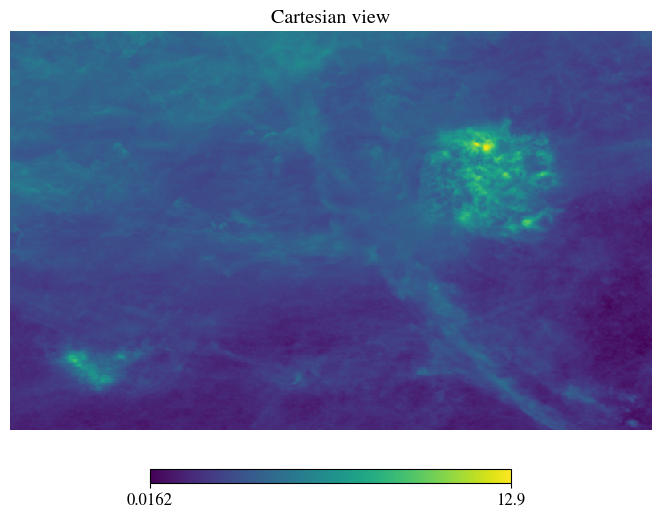

In [ ]:
lmc_glon = [270., 307.]
lmc_glat = [-48., -25.]
glon_cen = (lmc_glon[0]+lmc_glon[1])/2.
glat_cen = (lmc_glat[0]+lmc_glat[1])/2.

test = hp.cartview(ebv_map, return_projected_map=True, lonra=lmc_glon, latra=lmc_glat, norm='log')
plt.show()

## $F_{CNM}$, $N_{HI}$ and coordinates

In [129]:
mc_fg_res_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky'],
      dtype='object')

In [130]:
fcnm = mc_fg_res_df['fcnm'].values
sigfcnm = mc_fg_res_df['sigfcnm'].values
fcnm.shape

(462,)

In [131]:
nhi = mc_fg_res_df['nhi'].values
signhi = mc_fg_res_df['signhi'].values
nhi.shape

(462,)

# CNM Components

In [132]:
mc_fg_cpn_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

In [133]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

In [134]:
SMC_center_gl = cf.SMC['gl'] # deg
SMC_center_gb = cf.SMC['gb'] # deg
print(SMC_center_gl, SMC_center_gb)

302.0 -44.5


# Tspin: CNM components

In [136]:
mc_fg_cpn_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,...,0.453207,1.416348,0.171045,0.225989,0.028857,6.267342,0.260013,3.515802,1.600893,0.555026
687,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,...,0.790409,0.572984,0.057847,0.134791,0.073315,4.250919,2.271969,3.430639,0.597434,0.089552
688,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,...,0.503125,1.140123,0.059094,0.253422,0.017857,4.498908,0.214756,3.409348,1.106552,0.120073
689,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,...,0.503125,0.687252,0.052560,0.152760,0.013772,4.498908,0.214756,3.409348,0.666387,0.117329


In [137]:
mc_src_gl_cpn = mc_fg_cpn_df['glon'].values
mc_src_gb_cpn = mc_fg_cpn_df['glat'].values
len(mc_src_gb_cpn)

691

In [138]:
ts = mc_fg_cpn_df['tscnm'].values
sigts = mc_fg_cpn_df['sigtscnm'].values
ts.shape

(691,)

In [140]:
theta = (90. - mc_src_gb_cpn)*deg2rad
phi   = mc_src_gl_cpn*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

tau353_cpn = tau353_map[pix]
sigtau353_cpn = sigtau353_map[pix]

ebv_cpn = ebv_map[pix]
sigebv_cpn = np.sqrt(tau353_cpn**2*sigafactor**2 + afactor**2*sigtau353_cpn**2)
Av_cpn    = 3.1*ebv_cpn
sigAv_cpn = 3.1*sigebv_cpn
print(len(Av_cpn))
Av_cpn[:5]

691


array([0.14746952, 0.5524542 , 0.5524542 , 0.15837382, 0.17087734],
      dtype=float32)

# Dust radiance map

In [141]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")
radiance_map = hp.read_map(filename, field=3)
nside  = hp.get_nside(radiance_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [143]:
nside  = hp.get_nside(radiance_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


### For Tsmean along linesights

In [157]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

214


In [159]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

ts_mean_far = tspin_mean[id_far]
sigts_mean_far = sigtspin_mean[id_far]

290

# Dust temperature

In [163]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")
tdust_map = hp.read_map(filename, field=4)
nside  = hp.get_nside(tdust_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [164]:
sigtdust_map = hp.read_map(filename, field=5)
nside  = hp.get_nside(sigtdust_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


### For Tsmean along linesights

In [167]:
theta = (90. - bighicat_gb)*deg2rad
phi   = bighicat_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
bighicat_tdust    = tdust_map[pix]
bighicat_sigtdust = sigtdust_map[pix]
print(len(bighicat_tdust))
bighicat_tdust[:5]

199


array([19.65696 , 17.806295, 17.806295, 19.872324, 20.340628],
      dtype=float32)

In [168]:
theta = (90. - bighi_src_gb)*deg2rad
phi   = bighi_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

big_tau353    = tau353_map[pix]
big_sigtau353 = sigtau353_map[pix]
print(len(big_tau353))
print(big_tau353[:5])

big_tdust    = tdust_map[pix]
big_sigtdust = sigtdust_map[pix]
print(len(big_tdust))
big_tdust[:5]

214
[2.1937653e-06 1.1339677e-05 1.1339677e-05 4.3438708e-06 3.7796651e-06]
214


array([22.442572, 17.806295, 17.806295, 19.872324, 20.340628],
      dtype=float32)

In [169]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

big_tdust_far = big_tdust[id_far]
big_sigtdust_far = big_sigtdust[id_far]


big_tau353_far = big_tau353[id_far]
big_sigtau353_far = big_sigtau353[id_far]
print(len(big_tau353_far))

bighi_dens_ratio = 1.e5*big_tau353_far / bighi_nhi_src
print(bighi_dens_ratio.shape)

214
214
(214,)


In [170]:
# src infor
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
gaskap_tdust    = tdust_map[pix]
gaskap_sigtdust = sigtdust_map[pix]
print(len(gaskap_tdust))
gaskap_sigtdust[:5]

462


array([0.3137617 , 0.35070184, 0.44870234, 0.30038467, 0.30469796],
      dtype=float32)

In [171]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

ts_mean_far = tspin_mean[id_far]
sigts_mean_far = sigtspin_mean[id_far]

tau353_far    = tau353[id_far]
sigtau353_far = sigtau353[id_far]

nhi_4_tsmean_far = nhi_4_tsmean[id_far]
signhi_4_tsmean_far = signhi_4_tsmean[id_far]

dens_ratio = 1.e5*tau353_far / nhi_4_tsmean_far

gaskap_tdust_far = gaskap_tdust[id_far]
gaskap_sigtdust_far = gaskap_sigtdust[id_far]
len(gaskap_tdust_far)

290

In [182]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

big_tdust_far = big_tdust[id_far]
big_sigtdust_far = big_sigtdust[id_far]

(214,)
214


In [184]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]

290

In [189]:
vminmin = 0.04
vmaxmax = 0.22

# $F_{CNM}$ vs $A_V$: far from LMC and SMC

In [ ]:
SMC_center_gl = cf.SMC['gl'] # deg
SMC_center_gb = cf.SMC['gb'] # deg
print(SMC_center_gl, SMC_center_gb)

302.0 -44.5


In [ ]:
print(cf.R_SMC, cf.R_LMC)

3.0 5.0


In [ ]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)
id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

fcnm_far = fcnm[id_far]
sigfcnm_far = sigfcnm[id_far]

Av_far = Av[id_far]
sigAv_far = sigAv[id_far]



id_near = np.where( (d_from_LMC <= 6.) | (d_from_SMC <= 4.))[0]
glon_near = mc_src_gl[id_near]
glat_near = mc_src_gb[id_near]

fcnm_near = fcnm[id_near]
sigfcnm_near = sigfcnm[id_near]

Av_near = Av[id_near]
sigAv_near = sigAv[id_near]

In [ ]:
tau353_far = tau353[id_far]
sigtau353_far = sigtau353[id_far]
len(sigtau353_far)

290

In [ ]:
nnear = len(id_near)
nfar  = len(id_far)
print(f'N-near, N-far: {nnear, nfar}')

N-near, N-far: (172, 290)


In [ ]:
nnear + nfar

462

In [ ]:
nhi_far = nhi[id_far]
signhi_far = signhi[id_far]

nhi_near = nhi[id_near]
signhi_near = signhi[id_near]

In [ ]:
tsmean_far = tspin_mean[id_far]
sigtsmean_far = sigtspin_mean[id_far]

tsmean_near = tspin_mean[id_near]
sigtsmean_near = sigtspin_mean[id_near]

In [ ]:
scattering_high_av_id = np.where(Av_far > 0.35)[0]
av_high = Av_far[scattering_high_av_id]
sigav_high = sigAv_far[scattering_high_av_id]
nhi_high_av = nhi_far[scattering_high_av_id]
signhi_high_av = signhi_far[scattering_high_av_id]

glon_high_av = glon_far[scattering_high_av_id]
glat_high_av = glat_far[scattering_high_av_id]

In [ ]:
nabs_sources - len(id_near)

290

# Dust temperatures with background $A_V$

In [ ]:
# IMPORTANT: Sort here
idx_sorted = np.argsort(Av_far)
Av_far = Av_far[idx_sorted]
sigAv_far = sigAv_far[idx_sorted]

nhi_far = nhi_far[idx_sorted]
signhi_far = signhi_far[idx_sorted]

tau353_far = tau353_far[idx_sorted]
sigtau353_far = sigtau353_far[idx_sorted]

glon_far = glon_far[idx_sorted]
glat_far = glat_far[idx_sorted]

In [ ]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.88*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.

gl_cv = 238.
gb_cv = -5.
R_cv = 59.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [ ]:
c = SkyCoord(ch_xcirc, ch_ycirc, frame='galactic', unit='deg')
ch_xcirc_ra = c.fk5.ra.deg
ch_ycirc_dec = c.fk5.dec.deg
ch_xcirc_gl = c.l.deg
ch_ycirc_gb = c.b.deg

In [ ]:
c = SkyCoord(cv_xcirc, cv_ycirc, frame='galactic', unit='deg')
cv_xcirc_ra = c.fk5.ra.deg
cv_ycirc_dec = c.fk5.dec.deg

cv_xcirc_gl = c.l.deg
cv_ycirc_gb = c.b.deg

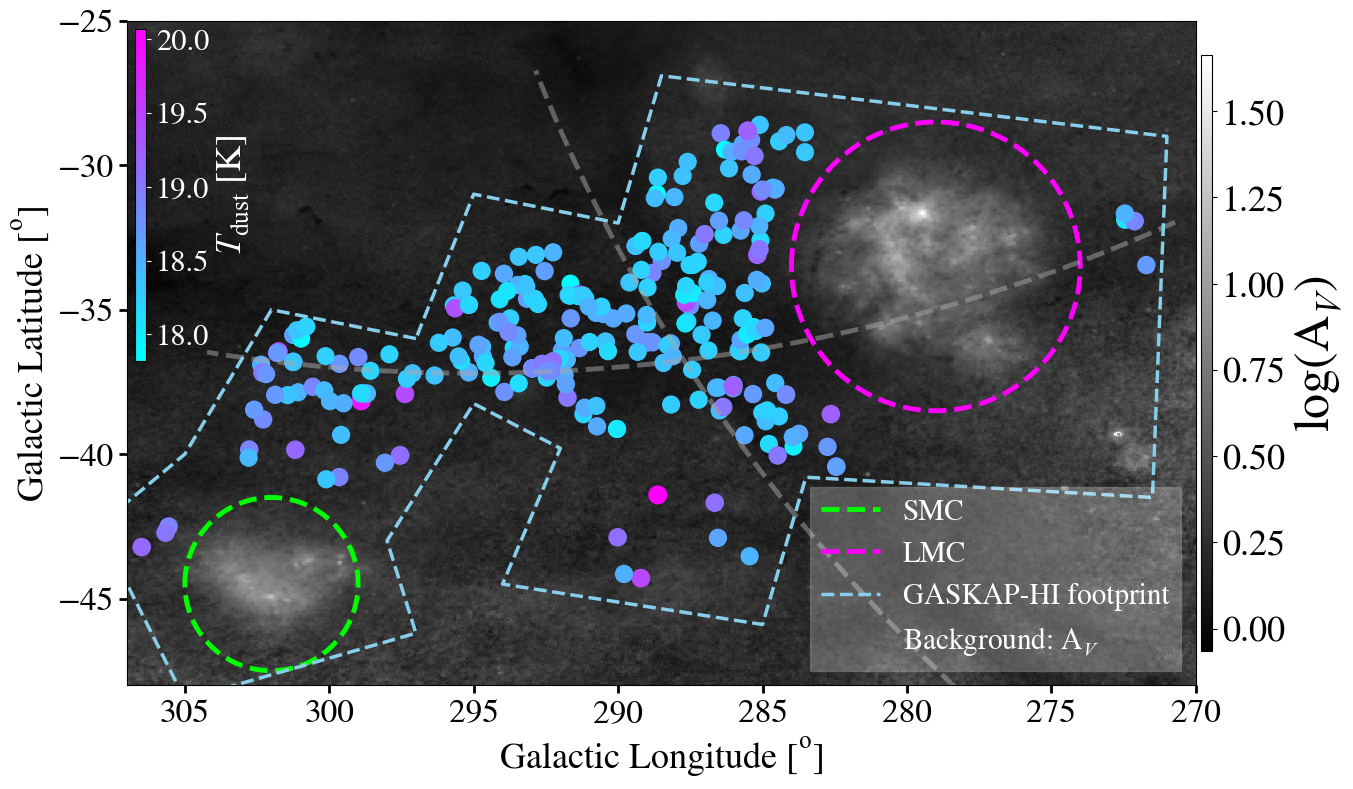

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot: 
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

cm = mpl.cm.get_cmap('cool')

# Approximate locations of LMC, SMC
ax.plot(SMC_xcirc, SMC_ycirc, lw=3.5, color='lime', ls='--', label='SMC')
ax.plot(LMC_xcirc, LMC_ycirc, lw=3.5, color='magenta', ls='--', label='LMC')

ax.plot(ch_xcirc_gl, ch_ycirc_gb,
        lw=3.5,
        c='darkgray',
        ls='--',
        alpha=0.5,
        label=''
       )


ax.plot(cv_xcirc_gl, cv_ycirc_gb,
        lw=3.5,
        c='darkgray',
        ls='--',
        alpha=0.5,
        label=''
       )

im = ax.imshow(np.log10(3.1*test), origin='lower',
               extent=(lmc_glon[1], lmc_glon[0], lmc_glat[0], lmc_glat[1]),
               cmap='gray', 
               interpolation='none')

sct = ax.scatter(glon_far, glat_far,
                  zorder=0, s=gaskap_tdust_far*8,
                  c=gaskap_tdust_far, marker='o', cmap=cm,
                  vmin=np.min(gaskap_tdust_far), vmax=np.max(gaskap_tdust_far),
                  label='')


ax.plot([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.],
 [-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.],
 ls='--', c='skyblue', lw=2.5,
 label='GASKAP-HI footprint') # transform=ax.get_transform('galactic')




ploti, = plt.plot([], [], '', label=r"Background: A$_V$")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=26)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=26)

ax.set_xlim(307., 270.)
ax.set_ylim(-48., -25.)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.01, pad=0.005, aspect=55)
cbar.ax.set_ylabel(r'log(A$_V$)', rotation=90, labelpad=5., fontsize=36)
cbar.ax.tick_params(labelsize=26)


ax.legend(loc='lower right', fancybox=False, framealpha=0.25, labelcolor='w', fontsize=21)



axins1 = inset_axes(ax,
                width="1%",
                height="50%",
                loc="upper left",
                )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(sct,
                cax=axins1,
                orientation='vertical',
                fraction=0.02,
                pad=0.1, aspect=95)
cbar.ax.set_ylabel('$T_\mathrm{dust}$ [K]', rotation=90, labelpad=5., fontsize=26, c='w')
cbar.ax.tick_params(colors='w', labelsize=22)

plt.show()